LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

#### Our Goal
Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contains our label.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')
df = pd.read_csv('lending_club_loan_two.csv')

In [3]:
print(data_info.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [4]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [5]:
feat_info('mort_acc')

Number of mortgage accounts.


In [6]:
## check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [7]:
##few variables with NULL values

### Exploratory Data Analysis

In [8]:
## Countplot of loan_status

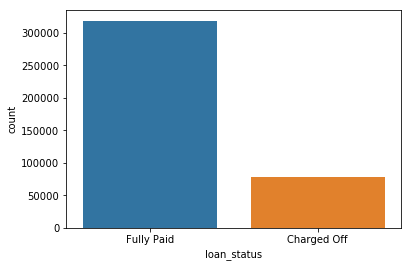

In [9]:
sns.countplot(df['loan_status'])

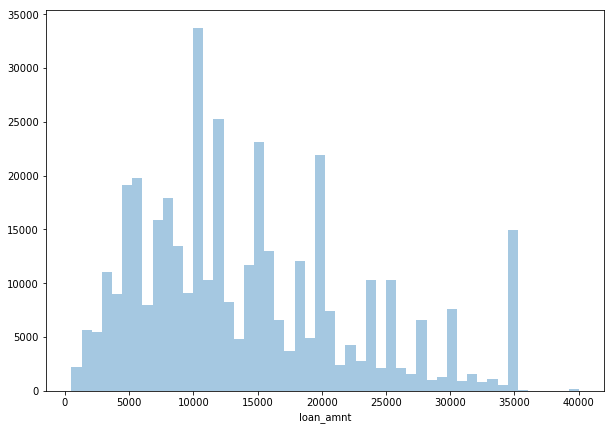

In [10]:
## historgram of loan amount column
plt.figure(figsize=(10,7))
sns.distplot(df['loan_amnt'], kde=False)

In [11]:
## Correlation between numerical variables
df_corr = df.select_dtypes(include=['float64'])
df_corr = df_corr.corr()

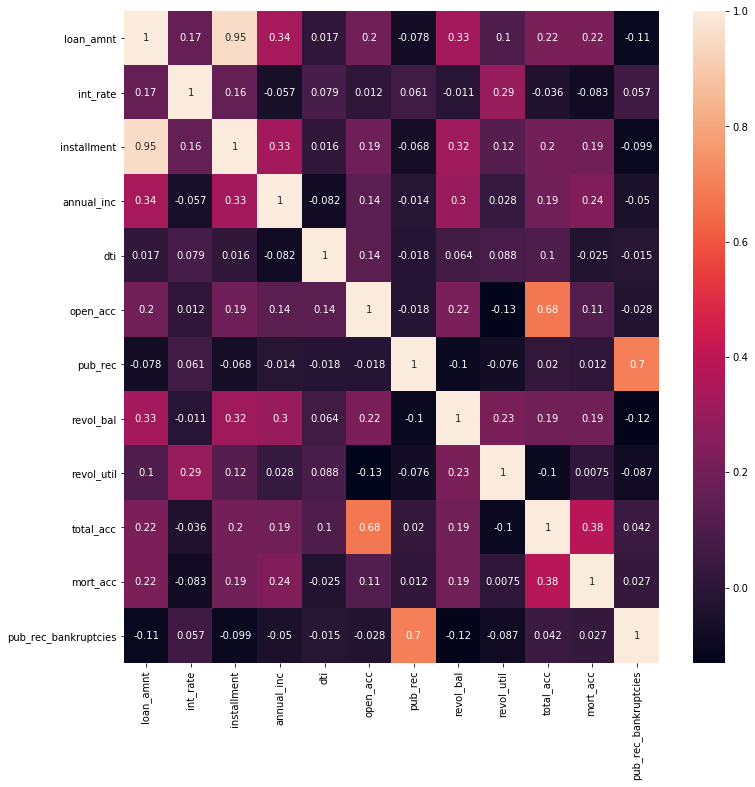

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(df_corr, annot=True)

almost perfect correlations between installment and loan_amount

In [13]:
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


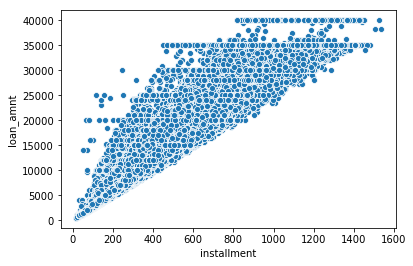

In [14]:
sns.scatterplot(x='installment', y='loan_amnt', data=df)

this seems like duplicate information, as the installment indicates a subset of the loan_amnt to be paid.

In [15]:
## drop installment variable
#df = df.drop['installment', axis =1]

#### a boxplot showing the relationship between the loan_status and the Loan Amount.

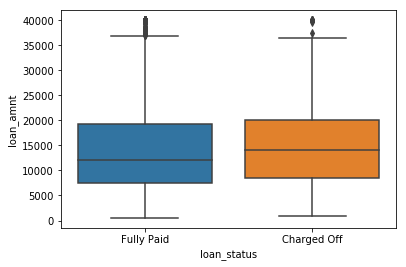

In [16]:
sns.boxplot(x='loan_status', y='loan_amnt', data = df)

#### summary statistics for the loan amount, grouped by the loan_status.

In [17]:
df['loan_amnt'].groupby(df['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [18]:
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [19]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

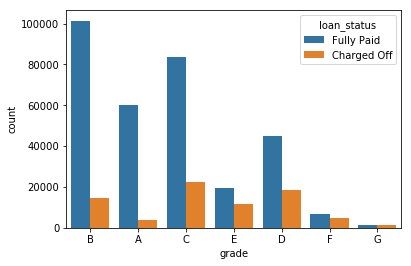

In [20]:
sns.countplot(df['grade'], hue='loan_status', data=df)

In [21]:
### count plot of loan sub_grades
plt.figure(figsize=(14,4))
df_grades = df['sub_grade'].sort_values(ascending=True)

sns.countplot(df['sub_grade'], data=df_grades)
#sns.countplot(df['sub_grade'], hue='loan_status', data=df, order=df['sub_grade'])

ValueError: min() arg is an empty sequence

 It looks like F and G subgrades don't get paid back that often. Isloate those and recreate the countplot just for those subgrades.

In [22]:
df_fg = df[(df.grade == 'F') | (df.grade =='G')]

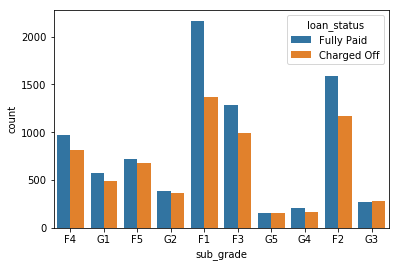

In [23]:
sns.countplot('sub_grade', data=df_fg, hue='loan_status')

between grades F & G, subgroups G5, G4, G3,F3 and others seem highly likely to fail

###### a new column called 'loan_repaid' which will contain a 1 if the loan status was "Fully Paid" and a 0 if it was "Charged Off".

In [24]:
loan_status = pd.get_dummies(df['loan_status'], drop_first=True)
loan_status.columns = ['loan_repaid']
loan_status.head(10)

,loan_repaid
0,1
1,1
2,1
3,1
4,0
5,1
6,1
7,1
8,1
9,1


In [25]:
df.drop(['loan_status'], axis=1,inplace=True)
df = pd.concat([df, loan_status], axis=1)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_repaid
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0


 ###### a bar plot showing the correlation of the numeric features to the new loan_repaid column. Helpful Link

In [30]:
df.plot.bar(df.corr()['loan_repaid'])

ValueError: Length mismatch: Expected axis has 396030 elements, new values have 13 elements